This notebook did the following steps for both RNN and CNN models
    1. training and perform hyperparmeter search on SNLI datasets
    2. plot validation accuracies and training loss for hyperparameter search
    3. save the best model
    4. examine correct and incorrect predictions

In [8]:
import torch
import pickle as pk
import numpy as np
import pandas as pd

In [9]:
snli_train_id = pk.load(open("./hw2_data/snli_train_id.pk", "rb"))
snli_val_id = pk.load(open("./hw2_data/snli_val_id.pk", "rb"))
loaded_embeddings_ft = pk.load(open("./hw2_data/loaded_embeddings_ft.pk", "rb"))

## RNN

* Architecture
    * single-layer, bi-directional GRU
    * Concat Premises hidden vector and Hypothesis hidden vector
    * feed to 2 FC layers with ReLU and Dropout to return a 1-by-3 vector. 
    
* Hyperparameter tuned
    * Hidden size = 100, 200, 300
    * Dropout rate = 0 (no dropout), 0.5

### train and hyperparameter searh

In [7]:
from rnn_trainer import rnn_trainer
hidden_size_list = [100,200,300]
dropout_list = [0,0.5]

args= {}
args['num_layers'] = 1
args['num_classes'] = 3
args['device'] = 'cuda'
args['batch_size'] = 64
args['optim'] = 'adam'
args['learning_rate'] = 3e-4
args['num_epochs'] = 30

for h in hidden_size_list[1:]:
    for d in dropout_list:
            args['hidden_size'] = h
            args['dropout'] = d
            trainer = rnn_trainer(snli_train_id, snli_val_id, loaded_embeddings_ft, args)
            train_list,val_list = trainer.go()

            pk.dump(val_list, open('./result/rnn_h=%s_d=%s_val_acc'%(h,d), 'wb'))
            pk.dump(train_list, open('./result/rnn_h=%s_d=%s_train_loss'%(h,d), 'wb'))
            print('finish hidden_size = %s, dropout = %s, val_acc = %s'%(h,d,val_list[-1]))


  0%|          | 0/30 [00:00<?, ?it/s]

finish hidden_size = 200, dropout = 0, val_acc = 68.0


  0%|          | 0/30 [00:00<?, ?it/s]

finish hidden_size = 200, dropout = 0.5, val_acc = 70.3


  0%|          | 0/30 [00:00<?, ?it/s]

finish hidden_size = 300, dropout = 0, val_acc = 68.0


100%|██████████| 30/30 [15:08<00:00, 30.28s/it]

finish hidden_size = 300, dropout = 0.5, val_acc = 70.0


### plot hyperparameter search results

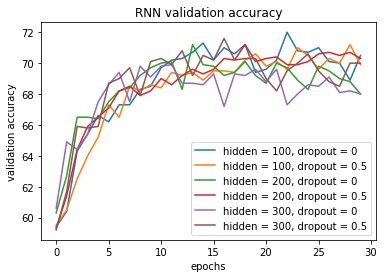

In [15]:
import matplotlib.pyplot as plt
hidden_size_list = [100,200,300]
dropout_list = [0,0.5]
for h in hidden_size_list:
    for d in dropout_list:
        val_acc = pk.load(open('./result/rnn_h=%s_d=%s_val_acc'%(h,d), 'rb'))
        plt.plot(range(len(val_acc)), val_acc, label = 'hidden = %s, dropout = %s' %(h,d))
        plt.title('RNN validation accuracy')
        plt.ylabel('validation accuracy')
        plt.xlabel('epochs')
        plt.legend()


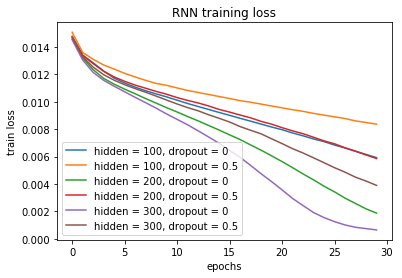

In [14]:
for h in hidden_size_list:
    for d in dropout_list:
        train_loss = pk.load(open('./result/rnn_h=%s_d=%s_train_loss'%(h,d), 'rb'))
        plt.plot(range(len(train_loss)), train_loss, label = 'hidden = %s, dropout = %s' %(h,d))
        plt.title('RNN training loss')
        plt.ylabel('train loss')
        plt.xlabel('epochs')
        plt.legend()

### save best model

In [19]:
from rnn_trainer import rnn_trainer

args= {}
args['num_layers'] = 1
args['num_classes'] = 3
args['device'] = 'cuda'
args['batch_size'] = 64
args['optim'] = 'adam'
args['learning_rate'] = 3e-4
args['num_epochs'] = 22
args['hidden_size'] = 100
args['dropout'] = 0

trainer = rnn_trainer(snli_train_id, snli_val_id, loaded_embeddings_ft, args)
_,_ = trainer.go()
trainer.save_model('best_models', 'RNN')

100%|██████████| 22/22 [26:05<00:00, 71.18s/it]


### sanity check on best model - print correct and wrong predictions

In [23]:
import torch
from models.rnn import RNN
from SNLI_DataLoader import SNLIDataset, snli_collate_func
import torch.nn.functional as F

In [24]:
model_path = 'best_models/RNN.pth'
with open(model_path, 'rb') as model_dict:
        checkpoint = torch.load(model_dict)
best_args = checkpoint['config_dict']

In [25]:
model = RNN(best_args, loaded_embeddings_ft)
model.load_state_dict(checkpoint['state_dict'])

In [26]:
val_dataset = SNLIDataset(snli_val_id)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=best_args['batch_size'],
                                           collate_fn=snli_collate_func,
                                           shuffle=False)
val_text = pd.read_csv('hw2_data/snli_val.tsv', sep = '\t')

In [27]:
model.eval()
for data in val_loader:
    prem, prem_len, hyp, hyp_len, labels = [data[i].to(best_args['device']) for i in range(len(data))]
    outputs = F.softmax(model(prem, prem_len, hyp, hyp_len), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    result = np.array(predicted.eq(labels.view_as(predicted)))
    correct = np.argwhere(result==1)[:,0]
    wrong = np.argwhere(result==0)[:,0]
    break

print('Correct Prediction:')
for i in correct:
    print('Premise: ', val_text.iloc[i]['sentence1'])
    print('Hypothesis: ', val_text.iloc[i]['sentence2'])
    print('label: ', val_text.iloc[i]['label'])
    print('\n')

print('Wrong Prediction:')
for i in wrong: #wrong[1] is too long
    pred_label_num = predicted[i]
    if pred_label_num == 0: pred_label = 'neutral'
    elif pred_label_num == 1: pred_label = 'entailment'
    else: pred_label = 'contradiction'
        
    print('Premise: ', val_text.iloc[i]['sentence1'])
    print('Hypothesis: ', val_text.iloc[i]['sentence2'])
    print('true label: ', val_text.iloc[i]['label'])
    
    print('predicted label: ', pred_label)
    print('\n')


Correct Prediction:
Premise:  bicycles stationed while a group of people socialize .
Hypothesis:  People get together near a stand of bicycles .
label:  entailment


Premise:  Man in overalls with two horses .
Hypothesis:  a man in overalls with two horses
label:  entailment


Premise:  Man observes a wavelength given off by an electronic device .
Hypothesis:  The man is examining what wavelength is given off by the device .
label:  entailment


Premise:  Two men are listening to music through headphones .
Hypothesis:  Two men listen to music .
label:  entailment


Premise:  Two women , one walking her dog the other pushing a stroller .
Hypothesis:  There is a snowstorm .
label:  contradiction


Premise:  A group of numbered participants walk down the street together .
Hypothesis:  Participants wait for the beginning of the walkathon .
label:  neutral


Premise:  A man wearing glasses is vacuuming an architects model .
Hypothesis:  There is a man vaucuming
label:  entailment


Premise:

## CNN

* Architecture
    * A 2-layer 1-D convolutional network with ReLU activations and Dropout layers. 
    * Perform Max-pool at the end to compress the hidden representation into a single vector. 
    * Concat Premises hidden vector and Hypothesis hidden vector
    * feed to 2 FC layers with ReLU to return a 1-by-3 vector. 
    
* Hyperparameters tuned
    * Hidden size: 100, 200, 300
    * Kernel size: 3, 5
    * Dropout rate: 0 (no dropout), 0.5

### train and hyperparameter search

In [2]:
from cnn_trainer import cnn_trainer

hidden_size_list = [100,200,300]
dropout_list = [0,0.5]
kernel_list = [3,5]

In [7]:
args= {}
args['num_layers'] = 1
args['num_classes'] = 3
args['device'] = 'cuda'
args['batch_size'] = 64
args['optim'] = 'adam'
args['learning_rate'] = 3e-4
args['num_epochs'] = 30

for h in hidden_size_list:
    for d in dropout_list:
        for k in kernel_list:
            args['hidden_size'] = h
            args['dropout'] = d
            args['kernel_size'] = k
            trainer = cnn_trainer(snli_train_id, snli_val_id, loaded_embeddings_ft, args)
            train_list,val_list = trainer.go()

            pk.dump(val_list, open('./result/cnn_h=%s_d=%s_k=%s_val_acc'%(h,d,k), 'wb'))
            pk.dump(train_list, open('./result/cnn_h=%s_d=%s_k=%s_train_loss'%(h,d,k), 'wb'))
            print('finish hidden_size = %s, dropout = %s, kernel = %s, val_acc = %s'%(h,d,k,val_list[-1]))


  0%|          | 0/30 [00:00<?, ?it/s]

finish hidden_size = 100, dropout = 0, kernel = 3, val_acc = 65.7


  0%|          | 0/30 [00:00<?, ?it/s]

finish hidden_size = 100, dropout = 0, kernel = 5, val_acc = 63.7


  0%|          | 0/30 [00:00<?, ?it/s]

finish hidden_size = 100, dropout = 0.5, kernel = 3, val_acc = 68.6


  0%|          | 0/30 [00:00<?, ?it/s]

finish hidden_size = 100, dropout = 0.5, kernel = 5, val_acc = 66.9


  0%|          | 0/30 [00:00<?, ?it/s]

finish hidden_size = 200, dropout = 0, kernel = 3, val_acc = 64.4


  0%|          | 0/30 [00:00<?, ?it/s]

finish hidden_size = 200, dropout = 0, kernel = 5, val_acc = 66.6


  0%|          | 0/30 [00:00<?, ?it/s]

finish hidden_size = 200, dropout = 0.5, kernel = 3, val_acc = 68.6


  0%|          | 0/30 [00:00<?, ?it/s]

finish hidden_size = 200, dropout = 0.5, kernel = 5, val_acc = 67.3


  0%|          | 0/30 [00:00<?, ?it/s]

finish hidden_size = 300, dropout = 0, kernel = 3, val_acc = 67.8


  0%|          | 0/30 [00:00<?, ?it/s]

finish hidden_size = 300, dropout = 0, kernel = 5, val_acc = 65.3


  0%|          | 0/30 [00:00<?, ?it/s]

finish hidden_size = 300, dropout = 0.5, kernel = 3, val_acc = 71.5


100%|██████████| 30/30 [08:04<00:00, 16.14s/it]

finish hidden_size = 300, dropout = 0.5, kernel = 5, val_acc = 66.9


### plot

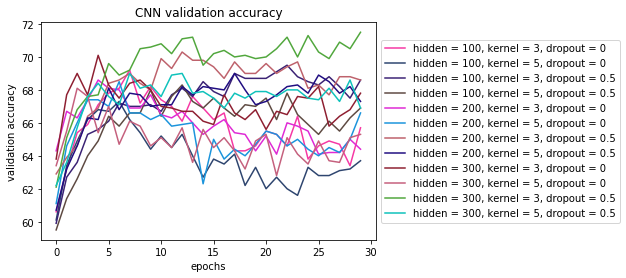

In [22]:
import matplotlib.pyplot as plt
hidden_size_list = [100,200,300]
dropout_list = [0,0.5]
kernel_list = [3,5]

for h in hidden_size_list:
    for d in dropout_list:
        for k in kernel_list:
            val_acc = pk.load(open('./result/cnn_h=%s_d=%s_k=%s_val_acc'%(h,d,k), 'rb'))
            plt.plot(range(len(val_acc)), val_acc, label = 'hidden = %s, kernel = %s, dropout = %s' %(h,k,d), c=np.random.rand(3,))
            plt.title('CNN validation accuracy')
            plt.ylabel('validation accuracy')
            plt.xlabel('epochs')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

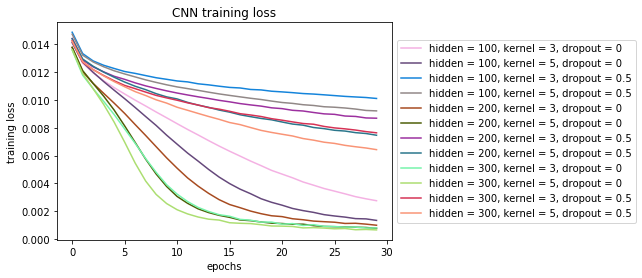

In [30]:
hidden_size_list = [100,200,300]
dropout_list = [0,0.5]
kernel_list = [3,5]

for h in hidden_size_list:
    for d in dropout_list:
        for k in kernel_list:
            train_loss = pk.load(open('./result/cnn_h=%s_d=%s_k=%s_train_loss'%(h,d,k), 'rb'))
            plt.plot(range(len(train_loss)), train_loss, label = 'hidden = %s, kernel = %s, dropout = %s' %(h,k,d), c=np.random.rand(3,))
            plt.title('CNN training loss')
            plt.ylabel('training loss')
            plt.xlabel('epochs')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### save best model

In [5]:
from cnn_trainer import cnn_trainer

args= {}
args['num_layers'] = 1
args['num_classes'] = 3
args['device'] = 'cuda'
args['batch_size'] = 64
args['optim'] = 'adam'
args['learning_rate'] = 3e-4
args['num_epochs'] = 30
args['hidden_size'] = 300
args['dropout'] = 0.5
args['kernel_size'] = 3

trainer = cnn_trainer(snli_train_id, snli_val_id, loaded_embeddings_ft, args)
_,_ = trainer.go()
trainer.save_model('best_models', 'CNN')

### sanity check on best model

In [5]:
import torch
from models.cnn import CNN
from SNLI_DataLoader import SNLIDataset, snli_collate_func
import torch.nn.functional as F

In [6]:
model_path = 'best_models/CNN.pth'
with open(model_path, 'rb') as model_dict:
        checkpoint = torch.load(model_dict)
best_args = checkpoint['config_dict']

In [10]:
model = CNN(best_args, loaded_embeddings_ft)
model.load_state_dict(checkpoint['state_dict'])

In [11]:
val_dataset = SNLIDataset(snli_val_id)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=best_args['batch_size'],
                                           collate_fn=snli_collate_func,
                                           shuffle=False)
val_text = pd.read_csv('hw2_data/snli_val.tsv', sep = '\t')

In [18]:
model.eval()
for data in val_loader:
    prem, prem_len, hyp, hyp_len, labels = [data[i].to(best_args['device']) for i in range(len(data))]
    outputs = F.softmax(model(prem, prem_len, hyp, hyp_len), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    result = np.array(predicted.eq(labels.view_as(predicted)))
    correct = np.argwhere(result==1)[:,0]
    wrong = np.argwhere(result==0)[:,0]
    break

print('Correct Prediction:')
for i in correct:
    print('Premise: ', val_text.iloc[i]['sentence1'])
    print('Hypothesis: ', val_text.iloc[i]['sentence2'])
    print('label: ', val_text.iloc[i]['label'])
    print('\n')

print('Wrong Prediction:')
for i in wrong: #wrong[1] is too long
    pred_label_num = predicted[i]
    if pred_label_num == 0: pred_label = 'neutral'
    elif pred_label_num == 1: pred_label = 'entailment'
    else: pred_label = 'contradiction'
        
    print('Premise: ', val_text.iloc[i]['sentence1'])
    print('Hypothesis: ', val_text.iloc[i]['sentence2'])
    print('true label: ', val_text.iloc[i]['label'])
    
    print('predicted label: ', pred_label)
    print('\n')


Correct Prediction:
Premise:  bicycles stationed while a group of people socialize .
Hypothesis:  People get together near a stand of bicycles .
label:  entailment


Premise:  Man in overalls with two horses .
Hypothesis:  a man in overalls with two horses
label:  entailment


Premise:  Two men are listening to music through headphones .
Hypothesis:  Two men listen to music .
label:  entailment


Premise:  Two women , one walking her dog the other pushing a stroller .
Hypothesis:  There is a snowstorm .
label:  contradiction


Premise:  A group of numbered participants walk down the street together .
Hypothesis:  Participants wait for the beginning of the walkathon .
label:  neutral


Premise:  A man wearing glasses is vacuuming an architects model .
Hypothesis:  There is a man vaucuming
label:  entailment


Premise:  A large group of people stand outside on a road while people on a higher level look on at them .
Hypothesis:  One group of people are watching what another group does .
l